# Segmentação das imagens EP3.1 

In [1]:
import os
from collections import defaultdict
from pathlib import Path

from dataclasses import dataclass

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from skimage import exposure, img_as_ubyte, img_as_bool, io 
from skimage.filters import threshold_otsu, try_all_threshold
from skimage.measure import label, regionprops
from skimage.transform import resize

In [2]:
EXAMPLE_IMAGE_PATH = Path('ground_truth') / 'brush' / 'gt_IMG_1431.JPG'

example_img = io.imread(EXAMPLE_IMAGE_PATH)

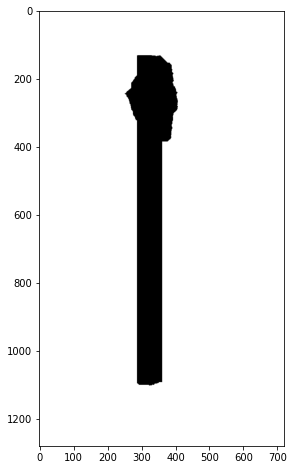

In [3]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.imshow(example_img, cmap='gray');

## Thresholding 

ADD DESCRIPTION AND PLOTS

In [4]:
def threshold_segmentation(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    
    return binary

In [5]:
ORIGINAL_GRAY_DATASET_PATH = Path('original_gray_dataset/')
SEGMENTED_DATASET_PATH = Path('segmented_dataset')

for filename in ORIGINAL_GRAY_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        segmented_path = f'{SEGMENTED_DATASET_PATH}/{object_class}'

        os.makedirs(segmented_path, exist_ok=True)
        
        img = io.imread(filename)
        segmented_img = threshold_segmentation(img)
        uint8_segmented_img = img_as_ubyte(segmented_img)
        io.imsave(f'{segmented_path}/{tail}', uint8_segmented_img)

## Cortar imagem na Feret Box

ADD DESCRIPTION AND PLOTS

In [6]:
object_class_dimensions = defaultdict(list)
def compute_bounding_box_img(img, object_class, manual_seg=False):
    minr, maxr, minc, maxc = compute_bounding_box_dimensions(img)
               
    if manual_seg:    
        object_class_dimensions[object_class].append([minr, maxr, minc, maxc])    
        
    if not manual_seg and maxr == 1280 and maxc == 720:
        minr, maxr, minc, maxc = average_object_dims[object_class]
    
    box_img = img[minr:maxr, minc:maxc]

    return ~box_img


def compute_bounding_box_dimensions(img):
    img = img < 255  # make image binary (False = white, True = black)
    
    label_image = label(img)
    
    area = 0
    minr, minc, maxr, maxc = np.zeros(4)
    
    for region in regionprops(label_image):
        if region.area >= 100:
            new_minr, new_minc, new_maxr, new_maxc = region.bbox
            new_area = (new_maxr - new_minr) * (new_maxc - new_minc)
            if new_area > area:
                area = new_area
                minr, minc, maxr, maxc = new_minr, new_minc, new_maxr, new_maxc
                
    return minr, maxr, minc, maxc

In [7]:
def flip_binary_img(img):
    """Have the object be black and the background be white."""
    img = img < 255
    
    r, c = img.shape
    true_sum = img.sum()
    
    if true_sum / (r * c) > 0.5:
        return ~img
        
    return img

In [8]:
GROUND_TRUTH_DATASET_PATH = Path('ground_truth/')
GROUND_TRUTH_FERET_BOX_DATASET_PATH = Path('ground_truth_feret_box/')

for filename in GROUND_TRUTH_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        
        box_path = f'{GROUND_TRUTH_FERET_BOX_DATASET_PATH}/{object_class}'

        os.makedirs(box_path, exist_ok=True)
        
        img = io.imread(filename)
        feret_box_img = compute_bounding_box_img(img, object_class, True)
        feret_box_flipped = flip_binary_img(feret_box_img)
        uint8_feret_box_img = img_as_ubyte(feret_box_flipped)
        io.imsave(f'{box_path}/{tail}', uint8_feret_box_img)

In [9]:
average_object_dims = {}

for k, v in object_class_dimensions.items():
    average_object_dims[k] = [int(np.mean(x)) for x in zip(*v)]

In [10]:
SEGMENTED_DATASET_PATH = Path('segmented_dataset')
SEGMENTED_FERET_BOX_DATASET_PATH = Path('segmented_feret_box/')

for filename in SEGMENTED_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        box_path = f'{SEGMENTED_FERET_BOX_DATASET_PATH}/{object_class}'

        os.makedirs(box_path, exist_ok=True)
        
        img = io.imread(filename)
        feret_box_img = compute_bounding_box_img(img, object_class, False)
        feret_box_flipped = flip_binary_img(feret_box_img)
        uint8_feret_box_img = img_as_ubyte(feret_box_flipped)
        io.imsave(f'{box_path}/{tail}', uint8_feret_box_img, check_contrast=False)

## Performance da segmentação por threshold

ADD DESCRIPTION AND PLOTS

In [2]:
@dataclass
class ImageStats:
    true_positive: int
    true_negative: int
    false_positive: int
    false_negative: int
        
    def accuracy(self) -> float:
        acc = (self.true_positive + self.true_negative) / (self.true_positive + self.true_negative + self.false_positive + self.false_negative)
        if np.isnan(acc):
            return 0
        return acc
    
    def precision(self) -> float:
        precision =  self.true_positive / (self.true_positive + self.false_positive)
        if np.isnan(precision):
            return 0
        return precision
    
    def recall(self) -> float:
        recall = self.true_positive / (self.true_positive + self.false_negative)
        if np.isnan(recall):
            return 0
        return recall


    
def img_performance_metrics(gt_img, seg_img_resize):
    tp, tn, fp, fn = np.zeros(4)
    for r in range(seg_img_resize.shape[0]):
        for c in range(seg_img_resize.shape[1]):
            gt_pixel = gt_img[r, c]
            seg_pixel = seg_img_resize[r, c]

            if gt_pixel == True and seg_pixel == True:
                tp += 1

            elif gt_pixel == False and seg_pixel == False:
                tn += 1

            elif gt_pixel == False and seg_pixel == True:
                fp += 1

            else:
                fn += 1

    img_stats = ImageStats(tp, tn, fp, fn)
    
    return img_stats

In [3]:
SEGMENTED_FERET_BOX_DATASET_PATH = Path('segmented_feret_box/')
GROUND_TRUTH_FERET_BOX_DATASET_PATH = Path('ground_truth_feret_box/')

class_metrics = defaultdict(list)

for filename in GROUND_TRUTH_FERET_BOX_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        gt_img = img_as_bool(io.imread(filename))
        
        segmented_head = head.replace('ground_truth_feret_box', 'segmented_feret_box')
        segmented_tail = tail.split('gt_')[-1]
        seg_img = io.imread(f'{segmented_head}/{segmented_tail}')
        
        seg_img_resize = img_as_bool(resize(seg_img, (gt_img.shape[0], gt_img.shape[1]), anti_aliasing=True, order=0))
        
        metrics = img_performance_metrics(gt_img, seg_img_resize)
        
        class_metrics[object_class].append(metrics)

In [4]:
final_report_metrics = defaultdict(list)

for k, v in class_metrics.items():
    
    mean_acc = np.mean([img_stats.accuracy() for img_stats in v])
    mean_precision = np.mean([img_stats.precision() for img_stats in v])
    mean_recall = np.mean([img_stats.recall() for img_stats in v])
    
    final_report_metrics[k] = [mean_acc, mean_precision, mean_recall]

/home/iblucher/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [10]:
df = pd.DataFrame.from_dict(final_report_metrics,orient='index')
df = df.rename(columns={0: 'Accuracy', 1: 'Precision', 2: 'Recall'}).round(2)

In [11]:
df

,Accuracy,Precision,Recall
earring,0.59,0.34,0.37
glasses,0.52,0.35,0.33
nail_polish,0.55,0.32,0.49
lipstick,0.69,0.42,0.42
hand_sanitizer,0.62,0.28,0.41
notebook,0.79,0.23,0.51
knife,0.59,0.39,0.38
pen,0.59,0.47,0.39
mug,0.65,0.40,0.54
brush,0.48,0.36,0.26


In [17]:
df.mean(axis='index').to_frame('Value')

,Value
Accuracy,0.607
Precision,0.356
Recall,0.410
